# LXMERT Visualization DEMO

This Notebook is based on the following: https://github.com/huggingface/transformers/tree/main/examples/research_projects/lxmert

Visualizations used are based on this paper: https://github.com/hila-chefer/Transformer-MM-Explainability

LXMERT is a very accurate at the expense of computation time. Because of the use of F-RCNN to obtain regions of interest, it takes a lot of time to process an image. 

<mark>Current Visualizations:</mark> Gradcam, Attention Rollout, Chefer bi-modal transformer explainability

In [1]:
from IPython.display import clear_output, Image, display
import PIL
import matplotlib.pyplot as plt
import numpy as np
from transformers import LxmertTokenizer

# We need to use a modified version of the lxmert model that's based on huggingface
from lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP 
import cv2 # For image visualizations
import copy # For attention rollout
import torch
import io
from frcnn.utils import Config, get_data
from frcnn.modeling_frcnn import GeneralizedRCNN
from frcnn.processing_image import Preprocess
from frcnn.visualizing_image import SingleImageViz

c:\Users\robin\Desktop\SeniorDesign2\VisualInspectionDeepLearning\Model Testing\Testing_Venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


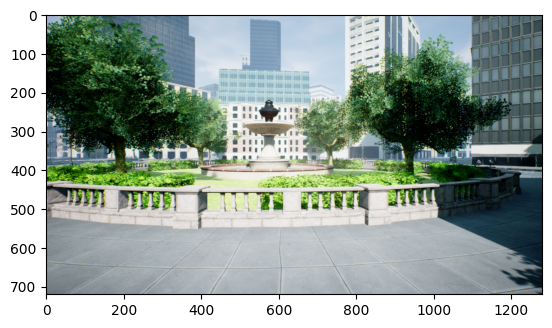

In [2]:
IMAGE_LOCATION = r"C:\Users\robin\Desktop\SeniorDesign2\VisualInspectionDeepLearning\Model Testing\AirSimImage.png"
image = PIL.Image.open(IMAGE_LOCATION)

image = cv2.imread(IMAGE_LOCATION)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [3]:
# Define the model 
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [4]:

# Visualization Creator Function
# Note: For best results, open the saved visualization
def create_image_vis(img, image_scores, rcnn_dict: dict, output_path: str) -> str:
    bbox_scores = image_scores

    mask = torch.zeros(img.shape[0], img.shape[1])
    print(mask.shape)

    for index in range(len(bbox_scores)):
        
        [x, y, w, h] = rcnn_dict.get("boxes")[0][index]
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])

    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img_multiplier = mask.numpy()
    img = img * img_multiplier
    img *= (255.0/img.max())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

    # Note: For some reason, the images don't display nicely unless they are written as files and then opened again
    cv2.imwrite(output_path, img)
    return output_path

In [5]:
# Extra Rules and Visualization Helper Functions

def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration
    num_tokens = all_layer_matrices[0].shape[1]
    eye = torch.eye(num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].matmul(joint_attention)
    return joint_attention

# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rules 6 + 7 from paper
def apply_self_attention_rules(R_ss, R_sq, cam_ss):
    R_sq_addition = torch.matmul(cam_ss, R_sq)
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition, R_sq_addition

# rules 10 + 11 from paper
def apply_mm_attention_rules(R_ss, R_qq, R_qs, cam_sq, apply_normalization=True, apply_self_in_rule_10=True):
    apply_normalization = False # Note: We don't apply normalization as it can assertion errors for some cases
    R_ss_normalized = R_ss
    R_qq_normalized = R_qq
    if apply_normalization:
        R_ss_normalized = handle_residual(R_ss)
        R_qq_normalized = handle_residual(R_qq)
    R_sq_addition = torch.matmul(R_ss_normalized.t(), torch.matmul(cam_sq, R_qq_normalized))
    if not apply_self_in_rule_10:
        R_sq_addition = cam_sq
    R_ss_addition = torch.matmul(cam_sq, R_qs)
    return R_sq_addition, R_ss_addition

# normalization- eq. 8+9
def handle_residual(orig_self_attention):
    self_attention = orig_self_attention.clone()
    diag_idx = range(self_attention.shape[-1])
    # computing R hat
    self_attention -= torch.eye(self_attention.shape[-1]).to(self_attention.device)
    
    assert self_attention[diag_idx, diag_idx].min() >= 0
    
    # normalizing R hat
    self_attention = self_attention / self_attention.sum(dim=-1, keepdim=True)
    self_attention += torch.eye(self_attention.shape[-1]).to(self_attention.device)
    return self_attention


In [6]:
class LxmertVisualizationGenerator: # Supports Bi-Modal Transformer Explainability, Gradcam, and Attention Rollout
    def __init__(self, model, rcnn_dict: dict, inputs, outputs, save_visualization=False):
        self.model = model
        self.rcnn_dict = rcnn_dict
        self.inputs = inputs
        self.outputs = outputs
        self.save_visualization = save_visualization

    def _gradcam(self, cam, grad):
        cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]) # Becomes (12, 36, 20)
        grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1]) 
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0)
        
        return cam

    def generate_attn_gradcam(self, index=None, method_name="gradcam"):
        output = self.outputs.question_answering_score
        model = self.model

        # initialize relevancy matrices
        text_tokens = len(self.inputs.input_ids.flatten()) # By default question length is 20
        image_bboxes = self.rcnn_dict.get("roi_features").shape[1] # Max of 36 Boxes for LXMERT

        # text self attention matrix
        self.R_t_t = torch.eye(text_tokens, text_tokens).to(model.device)
        # image self attention matrix
        self.R_i_i = torch.eye(image_bboxes, image_bboxes).to(model.device)
        # impact of images on text
        self.R_t_i = torch.zeros(text_tokens, image_bboxes).to(model.device)
        # impact of text on images
        self.R_i_t = torch.zeros(image_bboxes, text_tokens).to(model.device)


        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)

        model.zero_grad()
        one_hot.backward(retain_graph=True)

        # last cross attention + self- attention layer
        blk = model.lxmert.encoder.x_layers[-1]
        # cross attn cam will be the one used for the R_t_i matrix        
        grad_t_i = blk.visual_attention.att.get_attn_gradients()[-1].detach()
        cam_t_i = blk.visual_attention.att.get_attn()[-1].detach()
        cam_t_i = self._gradcam(cam_t_i, grad_t_i)
        # self.R_t_i = torch.matmul(self.R_t_t.t(), torch.matmul(cam_t_i, self.R_i_i))
        self.R_t_i = cam_t_i

        # language self attention
        grad = blk.lang_self_att.self.get_attn_gradients()[-1].detach()
        cam = blk.lang_self_att.self.get_attn()[-1].detach()
        self.R_t_t = self._gradcam(cam, grad)

        # disregard the [CLS] token itself
        self.R_t_t[0, 0] = 0
        return self.R_t_t, self.R_t_i
    
    def generate_rollout(self, method_name="rollout"):
        output = self.outputs.question_answering_score
        model = self.model

        # initialize relevancy matrices
        text_tokens = len(self.inputs.input_ids.flatten()) # By default question length is 20
        image_bboxes = self.rcnn_dict.get("roi_features").shape[1] # Max of 36 Boxes for LXMERT

        # text self attention matrix
        self.R_t_t = torch.eye(text_tokens, text_tokens).to(model.device)
        # image self attention matrix
        self.R_i_i = torch.eye(image_bboxes, image_bboxes).to(model.device)
        # impact of images on text
        self.R_t_i = torch.zeros(text_tokens, image_bboxes).to(model.device)
        # impact of text on images
        self.R_i_t = torch.zeros(image_bboxes, text_tokens).to(model.device)

        cams_text = []
        cams_image = []
        # language self attention
        blocks = model.lxmert.encoder.layer
        for blk in blocks:
            cam = blk.attention.self.get_attn()[-1].detach()
            cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]).mean(dim=0)
            cams_text.append(cam)


        # image self attention
        blocks = model.lxmert.encoder.r_layers
        for blk in blocks:
            cam = blk.attention.self.get_attn()[-1].detach()
            cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]).mean(dim=0)
            cams_image.append(cam)

        # cross attn layers
        blocks = model.lxmert.encoder.x_layers
        for i, blk in enumerate(blocks):
            # in the last cross attention module, only the text cross modal
            # attention has an impact on the CLS token, since it's the first
            # token in the language tokens
            if i == len(blocks) - 1:
                break

            # language self attention
            cam = blk.lang_self_att.self.get_attn()[-1].detach()
            cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]).mean(dim=0)
            cams_text.append(cam)

            # image self attention
            cam = blk.visn_self_att.self.get_attn()[-1].detach()
            cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]).mean(dim=0)
            cams_image.append(cam)


        # take care of last cross attention layer- only text
        blk = model.lxmert.encoder.x_layers[-1]
        # cross attn cam will be the one used for the R_t_i matrix
        cam_t_i = blk.visual_attention.att.get_attn()[-1].detach()
        cam_t_i = cam_t_i.reshape(-1, cam_t_i.shape[-2], cam_t_i.shape[-1]).mean(dim=0)
        self.R_t_t = compute_rollout_attention(copy.deepcopy(cams_text))
        self.R_i_i = compute_rollout_attention(cams_image)
        self.R_t_i = torch.matmul(self.R_t_t.t(), torch.matmul(cam_t_i, self.R_i_i))
        
        #self.R_t_i = torch.matmul(self.R_t_t.t(), torch.matmul(cam_t_i, self.R_i_i))
        # language self attention
        cam = blk.lang_self_att.self.get_attn()[-1].detach()
        cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]).mean(dim=0)
        cams_text.append(cam)

        self.R_t_t = compute_rollout_attention(cams_text)

        # disregard the [CLS] token itself
        self.R_t_t[0,0] = 0
        return self.R_t_t, self.R_t_i
    
    def _handle_self_attention_lang(self, blocks):
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()[-1].detach()
            if self.use_lrp:
                cam = blk.attention.self.get_attn_cam()[-1].detach()
            else:
                cam = blk.attention.self.get_attn()[-1].detach()
            cam = avg_heads(cam, grad)
            R_t_t_add, R_t_i_add = apply_self_attention_rules(self.R_t_t, self.R_t_i, cam)
            self.R_t_t += R_t_t_add
            self.R_t_i += R_t_i_add

    def _handle_self_attention_image(self, blocks):
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()[-1].detach()
            if self.use_lrp:
                cam = blk.attention.self.get_attn_cam()[-1].detach()
            else:
                cam = blk.attention.self.get_attn()[-1].detach()
            cam = avg_heads(cam, grad)
            R_i_i_add, R_i_t_add = apply_self_attention_rules(self.R_i_i, self.R_i_t, cam)
            self.R_i_i += R_i_i_add
            self.R_i_t += R_i_t_add

    def _handle_co_attn_self_lang(self, block):
        grad = block.lang_self_att.self.get_attn_gradients().detach()
        if self.use_lrp:
            cam = block.lang_self_att.self.get_attn_cam()[-1].detach()
        else:
            cam = block.lang_self_att.self.get_attn()[-1].detach()
        cam = avg_heads(cam, grad)
        R_t_t_add, R_t_i_add = apply_self_attention_rules(self.R_t_t, self.R_t_i, cam)
        self.R_t_t += R_t_t_add
        self.R_t_i += R_t_i_add

    def _handle_co_attn_self_image(self, block):
        grad = block.visn_self_att.self.get_attn_gradients()[-1].detach()
        if self.use_lrp:
            cam = block.visn_self_att.self.get_attn_cam()[-1].detach()
        else:
            cam = block.visn_self_att.self.get_attn()[-1].detach()
        cam = avg_heads(cam, grad)
        R_i_i_add, R_i_t_add = apply_self_attention_rules(self.R_i_i, self.R_i_t, cam)
        self.R_i_i += R_i_i_add
        self.R_i_t += R_i_t_add

    def _handle_co_attn_lang(self, block):
        if self.use_lrp:
            cam_t_i = block.visual_attention.att.get_attn_cam()[-1].detach()
        else:
            cam_t_i = block.visual_attention.att.get_attn()[-1].detach()
        grad_t_i = block.visual_attention.att.get_attn_gradients()[-1].detach()
        cam_t_i = avg_heads(cam_t_i, grad_t_i)
        R_t_i_addition, R_t_t_addition = apply_mm_attention_rules(self.R_t_t, self.R_i_i, self.R_i_t, cam_t_i,
                                                                  apply_normalization=self.normalize_self_attention,
                                                                  apply_self_in_rule_10=self.apply_self_in_rule_10)
        return R_t_i_addition, R_t_t_addition

    def _handle_co_attn_image(self, block):
        if self.use_lrp:
            cam_i_t = block.visual_attention_copy.att.get_attn_cam()[-1].detach()
        else:
            cam_i_t = block.visual_attention_copy.att.get_attn()[-1].detach()
        grad_i_t = block.visual_attention_copy.att.get_attn_gradients().detach()
        cam_i_t = avg_heads(cam_i_t, grad_i_t)
        R_i_t_addition, R_i_i_addition = apply_mm_attention_rules(self.R_i_i, self.R_t_t, self.R_t_i, cam_i_t,
                                                                  apply_normalization=self.normalize_self_attention,
                                                                  apply_self_in_rule_10=self.apply_self_in_rule_10)
        return R_i_t_addition, R_i_i_addition

    def generate_ours(self, index=None, use_lrp=True, normalize_self_attention=True, apply_self_in_rule_10=True, method_name="ours"):
        self.use_lrp = use_lrp
        self.use_lrp = False

        self.normalize_self_attention = normalize_self_attention
        self.apply_self_in_rule_10 = apply_self_in_rule_10
        kwargs = {"alpha": 1}
        output = self.outputs.question_answering_score
        model = self.model

        # initialize relevancy matrices
        text_tokens = len(self.inputs.input_ids.flatten()) # By default question length is 20
        image_bboxes = self.rcnn_dict.get("roi_features").shape[1] # Max of 36 Boxes for LXMERT

        # text self attention matrix
        self.R_t_t = torch.eye(text_tokens, text_tokens).to(model.device)
        # image self attention matrix
        self.R_i_i = torch.eye(image_bboxes, image_bboxes).to(model.device)
        # impact of images on text
        self.R_t_i = torch.zeros(text_tokens, image_bboxes).to(model.device)
        # impact of text on images
        self.R_i_t = torch.zeros(image_bboxes, text_tokens).to(model.device)

        if index is None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        # one_hot = torch.sum(one_hot.cuda() * output)
        one_hot = torch.sum(one_hot * output) # Currently don't support cuda. Make sure to fix cuda dependencies


        model.zero_grad()
        one_hot.backward(retain_graph=True)
        if self.use_lrp:
            model.relprop(torch.tensor(one_hot_vector).to(output.device), **kwargs)

        # language self attention
        blocks = model.lxmert.encoder.layer
        self._handle_self_attention_lang(blocks)

        # image self attention
        blocks = model.lxmert.encoder.r_layers
        self._handle_self_attention_image(blocks)

        # cross attn layers
        blocks = model.lxmert.encoder.x_layers
        for i, blk in enumerate(blocks):
            # in the last cross attention module, only the text cross modal
            # attention has an impact on the CLS token, since it's the first
            # token in the language tokens
            if i == len(blocks) - 1:
                break
            # cross attn- first for language then for image
            R_t_i_addition, R_t_t_addition = self._handle_co_attn_lang(blk)
            R_i_t_addition, R_i_i_addition = self._handle_co_attn_image(blk)

            self.R_t_i += R_t_i_addition
            self.R_t_t += R_t_t_addition
            self.R_i_t += R_i_t_addition
            self.R_i_i += R_i_i_addition

            # language self attention
            self._handle_co_attn_self_lang(blk)

            # image self attention
            self._handle_co_attn_self_image(blk)


        # take care of last cross attention layer- only text
        blk = model.lxmert.encoder.x_layers[-1]
        # cross attn- first for language then for image
        R_t_i_addition, R_t_t_addition = self._handle_co_attn_lang(blk)
        self.R_t_i += R_t_i_addition
        self.R_t_t += R_t_t_addition

        # language self attention
        self._handle_co_attn_self_lang(blk)

        # disregard the [CLS] token itself
        self.R_t_t[0,0] = 0
        return self.R_t_t, self.R_t_i


In [7]:
# Setup Faster RCNN Model for visual embeddings

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at C:\Users\robin/.cache\torch\transformers\57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [8]:
# run frcnn
images, sizes, scales_yx = image_preprocess(IMAGE_LOCATION)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print(output_dict.keys())

c:\Users\robin\Desktop\SeniorDesign2\VisualInspectionDeepLearning\Model Testing\Testing_Venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


odict_keys(['obj_ids', 'obj_probs', 'attr_ids', 'attr_probs', 'boxes', 'sizes', 'preds_per_image', 'roi_features', 'normalized_boxes'])


In [9]:
# Image Visualization

OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"

objids = get_data(OBJ_URL)
attrids = get_data(ATTR_URL)

frcnn_visualizer = SingleImageViz(IMAGE_LOCATION, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)

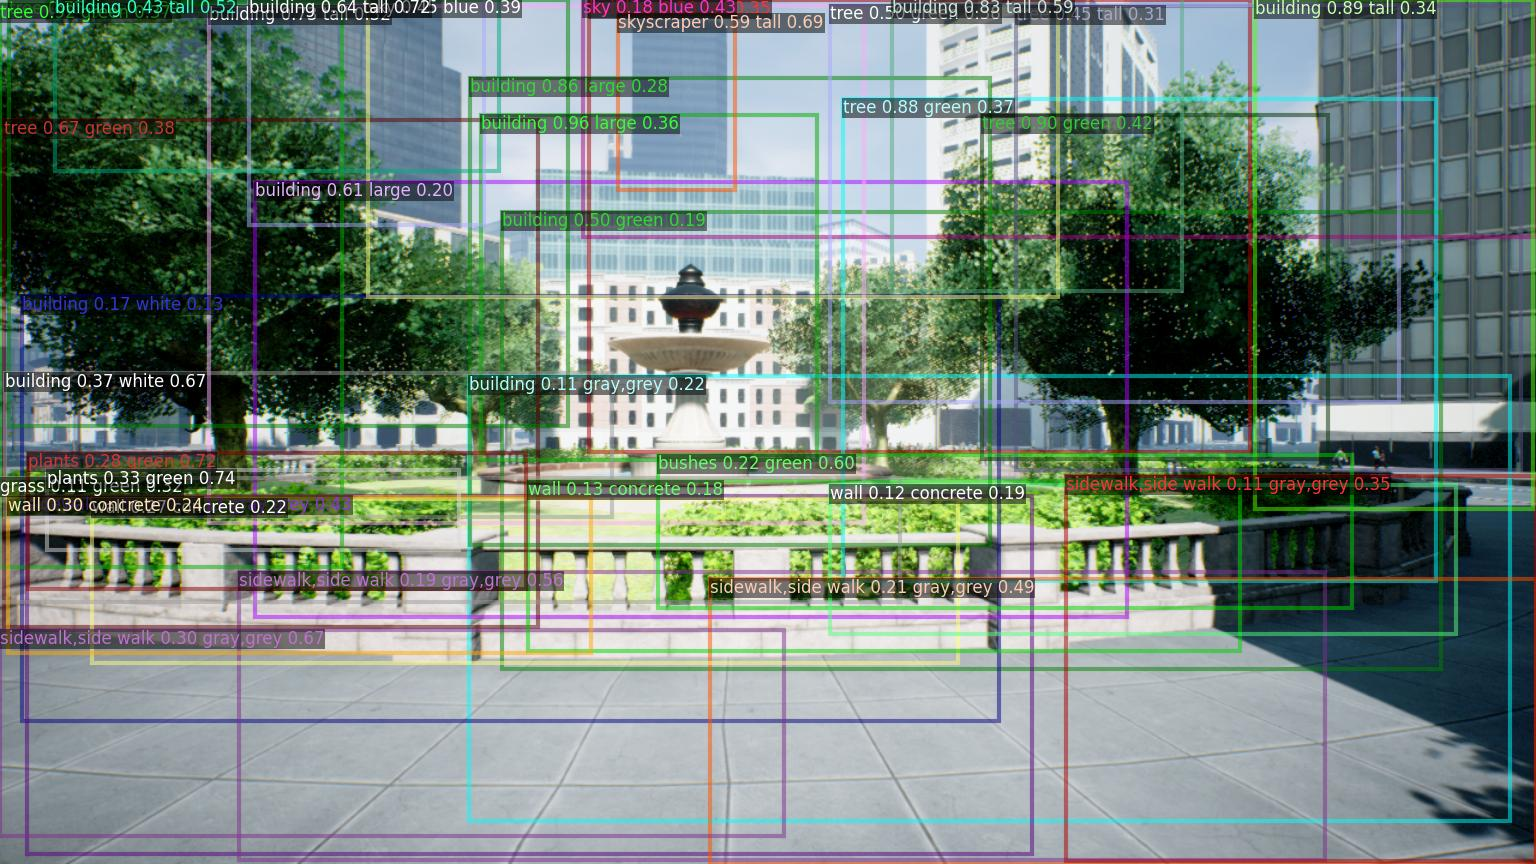

In [10]:
# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
showarray(frcnn_visualizer._get_buffer())


In [11]:
def getTopPredictions(vqa_raw_scores, vocab_dictionary):
    '''
    vqa_raw_scores is a Tensor containing the final classification scores of the model

    vocab_dictionary is a dictionary mapping the model output indicies to the corresponding words

    Returns a list of tuples with a word and corresponding score
    '''
    sm = torch.nn.Softmax(dim=0)
    probabilities = sm(vqa_raw_scores)
    top_answer_ids = probabilities.argsort()[-5:]
    top_predictions = []
    for id in top_answer_ids:
        id = int(id) # Type conversion to ensure we are working with ints and not tensors
        answer : str = vocab_dictionary[id]
        prob : float = probabilities[id]
        top_predictions.append((answer, prob))
    
    return top_predictions

In [12]:
# Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

questions = [
             #"How many trees are there?"
             "Is there a fountain?"
             #"What color is the tree?"
            ]

VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = get_data(VQA_URL)

vision_attentions = None
language_attentions = None
cross_attentions = None
tokens = None

for test_question in questions:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    # run lxmert
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=True,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)

    # Tracking the attentions
    vision_attentions = output_vqa['vision_attentions']
    language_attentions = output_vqa['language_attentions']
    cross_attentions = output_vqa['cross_encoder_attentions']

    top_predictions = getTopPredictions(output_vqa["question_answering_score"][0], vqa_answers)

    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

    for top_prediction in top_predictions:
        print(f"{top_prediction[0]} : {top_prediction[1]:.5f}")
   

    visualization_generator = LxmertVisualizationGenerator(lxmert_vqa, output_dict, inputs, output_vqa)

    # Chefer Explainability
    _, R_t_i = visualization_generator.generate_ours()
    our_image_scores = torch.sum(R_t_i, dim=0)

    # Gradcam Image Scores
    _, R_t_i = visualization_generator.generate_attn_gradcam()
    # Get all of the image scores across the 12 attention heads
    gradcam_image_scores = torch.sum(R_t_i, dim=0)
    
    # Attention Rollout Image Scores
    _, R_t_i = visualization_generator.generate_rollout()
    # Get all of the image scores across the 12 attention heads
    attention_rollout_image_scores = torch.sum(R_t_i, dim=0)

    our_image_scores


Question: ['Is there a fountain?']
prediction from LXMERT VQA: yes
no grass : 0.00000
20 ft : 0.00000
marker : 0.00000
no : 0.00225
yes : 0.99774


In [13]:
import cv2
cv2_image = cv2.imread(IMAGE_LOCATION)

gradcam_image = create_image_vis(cv2_image, gradcam_image_scores, output_dict, r"./test1.jpg")
attention_rollout_image = create_image_vis(cv2_image, attention_rollout_image_scores, output_dict, r"./test2.jpg")
our_image = create_image_vis(cv2_image, our_image_scores, output_dict, r"./test3.jpg")

torch.Size([720, 1280])
torch.Size([720, 1280])
torch.Size([720, 1280])


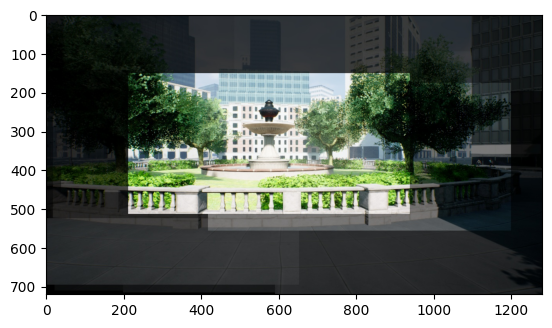

In [14]:
# Our Image
PIL.Image.open(r"./test3.jpg")
our_image

im_test = cv2.imread(r"./test3.jpg", )
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)

plt.imshow(im_test)

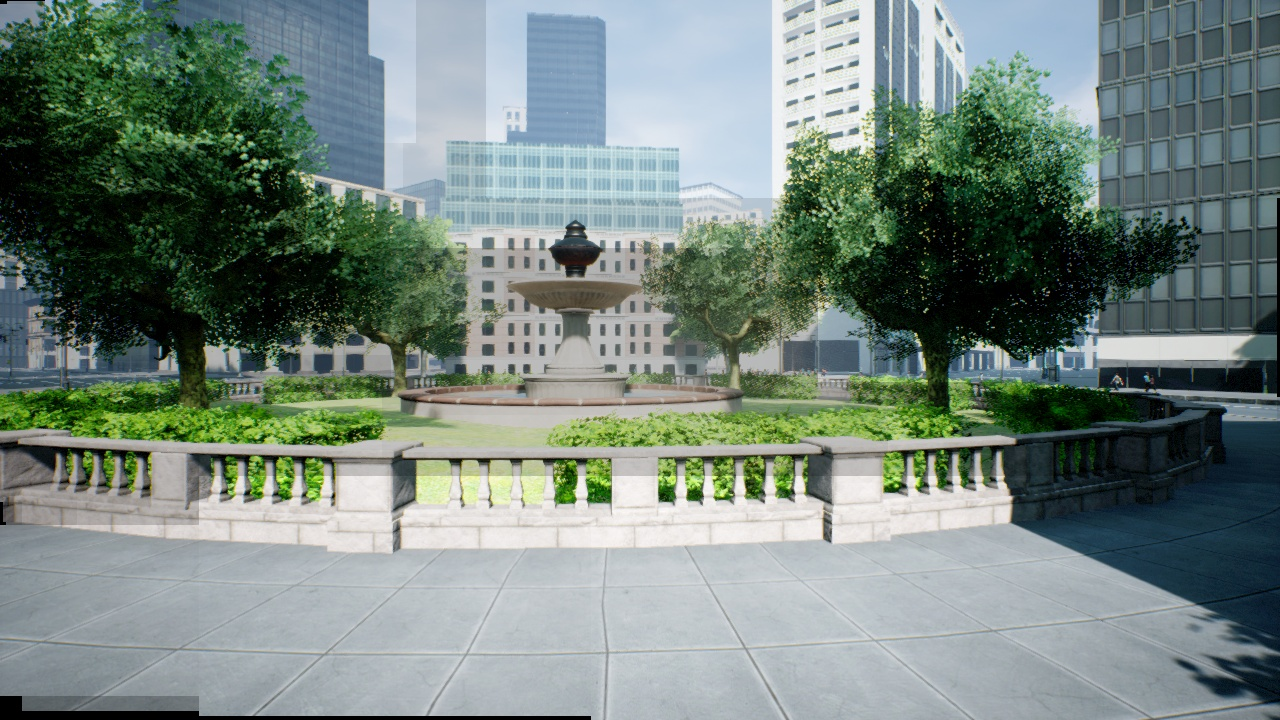

In [15]:
# Attention Rollout
PIL.Image.open(r"./test2.jpg")


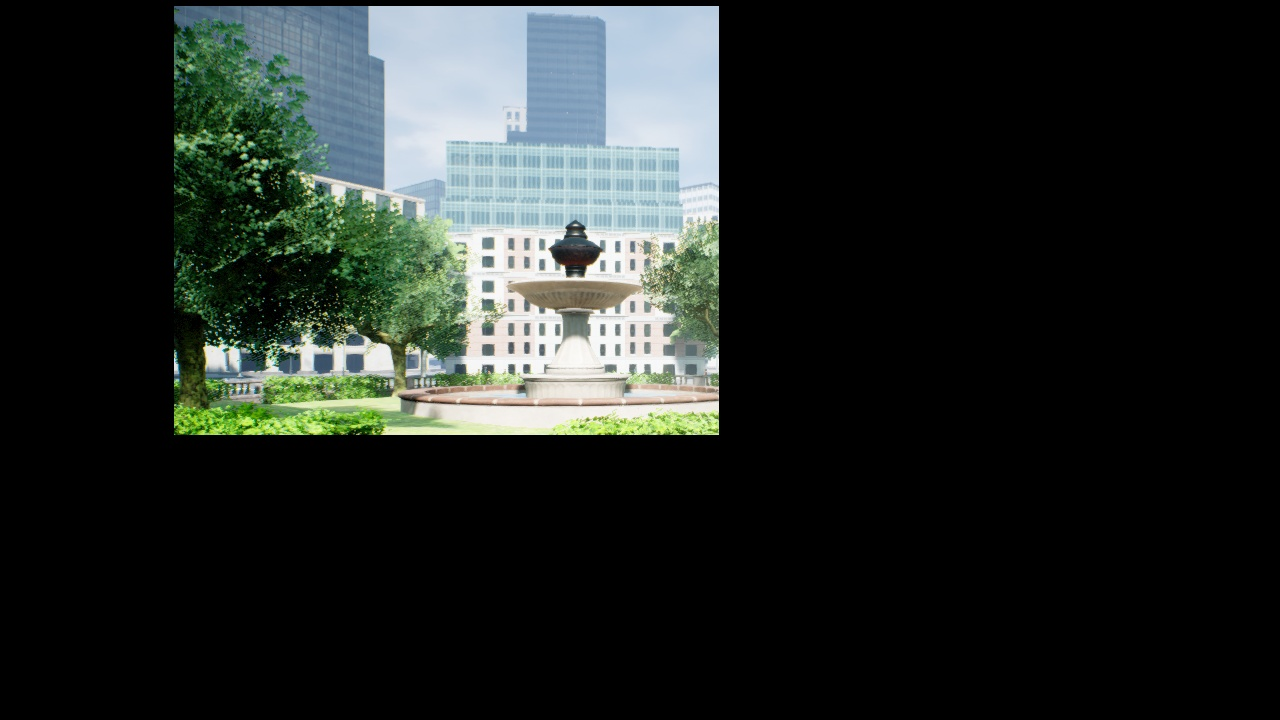

In [16]:
# Gradcam Image
PIL.Image.open(r"./test1.jpg")
